# Prototypical Networks

- Few-shot classification model

In [18]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [20]:
def _validate_root_dir(root):
    # todo: raise exception or warning
    pass

def _validate_train_flag(train: bool, test: bool):
    assert [train, test].count(True)==1, "one of train, valid & test must be true."        

class CustomDataset(Dataset):
    def __init__(self, root, train: bool = False, test: bool = False, transform=None, target_transform=None):
        _validate_root_dir(root)
        _validate_train_flag(train, test)
        self.transform = transform
        self.target_transform = target_transform
        if train:
            self.data_dir = Path(root) / 'train'
        elif test:
            self.data_dir = Path(root) / 'test'

        self._image_paths = sorted(
            list(self.data_dir.glob("**/*.jpg")) +
            list(self.data_dir.glob("**/*.jpeg")) +
            list(self.data_dir.glob("**/*.png")))
        self._image_labels = [str(i.parent.name) for i in self._image_paths]
        assert len(self._image_paths) == len(self._image_labels)

        # Create label mapping
        unique_labels = sorted(set(self._image_labels))
        self.label_mapping = {label: i for i, label in enumerate(unique_labels)}

    def __getitem__(self, idx):
        x = Image.open(str(self._image_paths[idx]))
        y = self._image_labels[idx]

        if self.transform:
            x = self.transform(x)

        # Convert label to integer using label mapping
        y = self.label_mapping[y]

        return x, y

    def get_labels(self):
        return self._image_labels

In [21]:
image_size = 128

from pathlib import Path
import numpy as np


# 데이터 경로 설정
data_path = '/workspace/classification_exp/dataset/split/LogoDet-3K/Medical'


train_set = CustomDataset(
    root=data_path,
    train=True,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            # transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)

test_set = CustomDataset(
    root=data_path,
    test=True,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            # transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),  
        ]
    ),
)

In [22]:
len(np.unique(test_set.get_labels()))

47

Backbone : ResNet18

In [23]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
# print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

In [38]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



N_WAY = len(np.unique(test_set.get_labels()))  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 1  # Number of images per class in the query set
N_EVALUATION_TASKS = 1000
N_TRAINING_EPISODES = 40000



# test_set.get_labels = test_set.get_labels()




test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


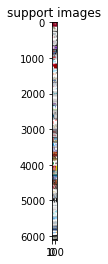

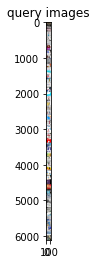

In [39]:
from PIL import Image  # Import the Image class


(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [28]:
model.eval()

example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

# ...

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}"
    )



Ground Truth / Predicted
27 / 30
5 / 3
1 / 17
38 / 22
34 / 20
33 / 3
0 / 34
44 / 42
7 / 18
41 / 46
30 / 3
11 / 10
4 / 12
35 / 3
23 / 22
14 / 18
39 / 16
17 / 17
3 / 3
32 / 24
45 / 16
37 / 17
16 / 39
20 / 18
29 / 16
40 / 31
15 / 26
31 / 24
8 / 8
46 / 15
28 / 28
10 / 18
26 / 21
43 / 43
12 / 19
42 / 43
22 / 34
2 / 0
24 / 24
19 / 15
13 / 3
9 / 30
21 / 22
25 / 16
6 / 15
36 / 3
18 / 17


## Zero shot task

In [29]:
from PIL import Image  # Import the Image class


def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:06<00:00, 15.32it/s]

Model tested on 100 tasks. Accuracy: 13.60%


### Episodic training
- Iterate over a large number of randomly generated few-shot classification tasks

In [30]:
# train_set.get_labels = lambda: train_set.targets.tolist()

N_WAY = len(np.unique(test_set.get_labels()))  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 3  # Number of images per class in the query set
N_TRAINING_EPISODES = 40000

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)


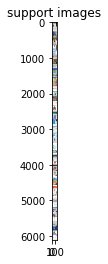

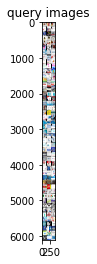

In [31]:
from PIL import Image  # Import the Image class


(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

## Few shot task(Training)

In [33]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 40000/40000 [59:30<00:00, 11.20it/s, loss=0.181]  


In [40]:
evaluate(test_loader)

100%|██████████| 1000/1000 [00:44<00:00, 22.48it/s]

Model tested on 1000 tasks. Accuracy: 76.95%


In [14]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average


In [15]:
def _validate_root_dir(root):
    # todo: raise exception or warning
    pass

def _validate_train_flag(train: bool, test: bool):
    assert [train, test].count(True)==1, "one of train, valid & test must be true."        

class CustomDataset(Dataset):
    def __init__(self, root, train: bool = False, test: bool = False, transform=None, target_transform=None):
        _validate_root_dir(root)
        _validate_train_flag(train, test)
        self.transform = transform
        self.target_transform = target_transform
        if train:
            self.data_dir = Path(root) / 'train'
        elif test:
            self.data_dir = Path(root) / 'test'

        self._image_paths = sorted(
            list(self.data_dir.glob("**/*.jpg")) +
            list(self.data_dir.glob("**/*.jpeg")) +
            list(self.data_dir.glob("**/*.png")))
        self._image_labels = [str(i.parent.name) for i in self._image_paths]
        assert len(self._image_paths) == len(self._image_labels)

        # Create label mapping
        unique_labels = sorted(set(self._image_labels))
        self.label_mapping = {label: i for i, label in enumerate(unique_labels)}

    def __getitem__(self, idx):
        x = Image.open(str(self._image_paths[idx]))
        y = self._image_labels[idx]

        if self.transform:
            x = self.transform(x)

        # Convert label to integer using label mapping
        y = self.label_mapping[y]

        return x, y
    
    def __len__(self):
        return len(self._image_paths)

    def get_labels(self):
        return self._image_labels

In [16]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

In [17]:
from PIL import Image  # Import the Image class


def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

# Zero Shot (Clothes)

In [18]:
from pathlib import Path
import numpy as np

# class_list = ['Clothes', 'Electronic', 'Food', 'Leisure', 'Medical', 'Necessities', 'Others', 'Sports', 'Transportation']
class_list = ['Clothes', 'Electronic', 'Food', 'Leisure', 'Medical', 'Necessities', 'Others', 'Sports', 'Transportation']

image_size = 128

# 데이터 경로 설정
data_path = f'/workspace/classification_exp/dataset/split/LogoDet-3K/{class_list[0]}'


train_set = CustomDataset(
    root=data_path,
    train=True,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            # transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)

test_set = CustomDataset(
    root=data_path,
    test=True,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            # transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),  
        ]
    ),
)

N_WAY = len(np.unique(test_set.get_labels()))  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 1  # Number of images per class in the query set
N_EVALUATION_TASKS = 100
N_TRAINING_EPISODES = 40000

In [19]:
test_sampler = TaskSampler(
test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


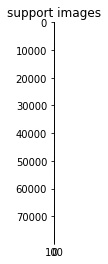

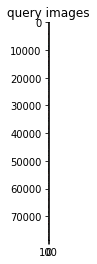

In [20]:
from PIL import Image  # Import the Image class


(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [21]:
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()

model = PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
model.eval()

example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

evaluate(test_loader)

100%|██████████| 100/100 [00:41<00:00,  2.40it/s]

Model tested on 100 tasks. Accuracy: 9.60%
